# **ProyekTimeSeries**

Nama : Muhammad Sahrul

Email : m.sahrul59@gmail.com

ID Dicoding : sahrul57

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sahrul59","key":"a2a0b57736f84e06bf56dc1d47197e48"}'}

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d patrickfleith/daily-sunspots-dataset

  0% 0.00/589k [00:00<?, ?B/s]
100% 589k/589k [00:00<00:00, 152MB/s]


In [6]:
!unzip daily-sunspots-dataset.zip

Archive:  daily-sunspots-dataset.zip
  inflating: daily_sunspots_time_series_1850_2023.csv  


In [7]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [8]:
df = pd.read_csv('/content/daily_sunspots_time_series_1850_2023.csv')
df

,date,year,month,day,date_frac,counts,std,nobs,indicator
0,1850-01-01,1850,1,1,1850.001,253,19.6,1,NaN
1,1850-01-02,1850,1,2,1850.004,162,15.5,1,NaN
2,1850-01-03,1850,1,3,1850.007,217,18.1,1,NaN
3,1850-01-04,1850,1,4,1850.010,99,12.0,1,NaN
4,1850-01-05,1850,1,5,1850.012,108,12.6,1,NaN
...,...,...,...,...,...,...,...,...,...
63425,2023-08-27,2023,8,27,2023.653,84,10.5,31,*
63426,2023-08-28,2023,8,28,2023.656,84,12.3,36,*
63427,2023-08-29,2023,8,29,2023.659,88,11.8,28,*
63428,2023-08-30,2023,8,30,2023.662,104,14.8,32,*


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63430 entries, 0 to 63429
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       63430 non-null  object 
 1   year       63430 non-null  int64  
 2   month      63430 non-null  int64  
 3   day        63430 non-null  int64  
 4   date_frac  63430 non-null  float64
 5   counts     63430 non-null  int64  
 6   std        63430 non-null  float64
 7   nobs       63430 non-null  int64  
 8   indicator  153 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 4.4+ MB


In [10]:
df.isnull().sum()

date             0
year             0
month            0
day              0
date_frac        0
counts           0
std              0
nobs             0
indicator    63277
dtype: int64

In [11]:
df = df.drop(columns=['date', 'indicator'])
df.head()

,year,month,day,date_frac,counts,std,nobs
0,1850,1,1,1850.001,253,19.6,1
1,1850,1,2,1850.004,162,15.5,1
2,1850,1,3,1850.007,217,18.1,1
3,1850,1,4,1850.010,99,12.0,1
4,1850,1,5,1850.012,108,12.6,1


In [12]:
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_data = pd.DataFrame(scaled_data, columns=df.columns)
scaled_data.head()

,year,month,day,date_frac,counts,std,nobs
0,-1.722092,-1.599955,-1.673792,-1.732043,2.205833,2.831092,-0.496218
1,-1.722092,-1.599955,-1.560155,-1.731983,1.023122,1.906662,-0.496218
2,-1.722092,-1.599955,-1.446518,-1.731923,1.737947,2.492886,-0.496218
3,-1.722092,-1.599955,-1.332880,-1.731863,0.204323,1.117514,-0.496218
4,-1.722092,-1.599955,-1.219243,-1.731823,0.321294,1.252796,-0.496218


In [13]:
series = scaled_data['counts'].values
time_step = scaled_data['year'].values

In [14]:
series

array([2.20583261, 1.02312235, 1.73794723, ..., 0.06135796, 0.26930702,
       0.08735159])

Text(0.5, 1.0, 'Sunspot Counts Over Years')

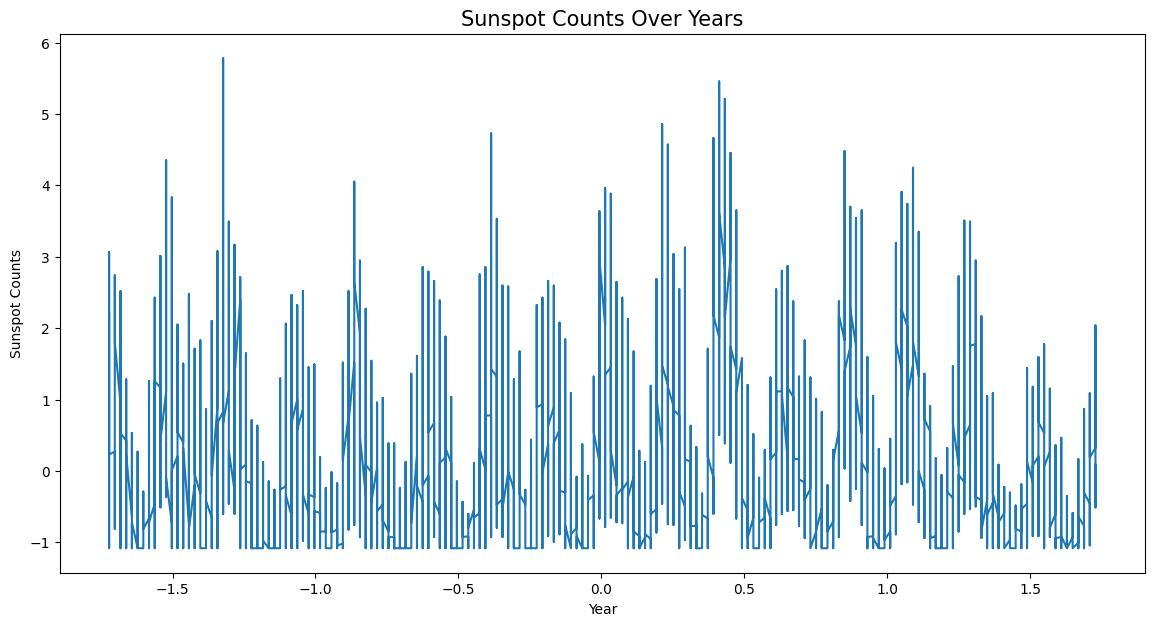

In [15]:
plt.figure(figsize=(14,7))
plt.plot(time_step, series)
plt.xlabel('Year')
plt.ylabel('Sunspot Counts')
plt.title('Sunspot Counts Over Years',
          fontsize=15)

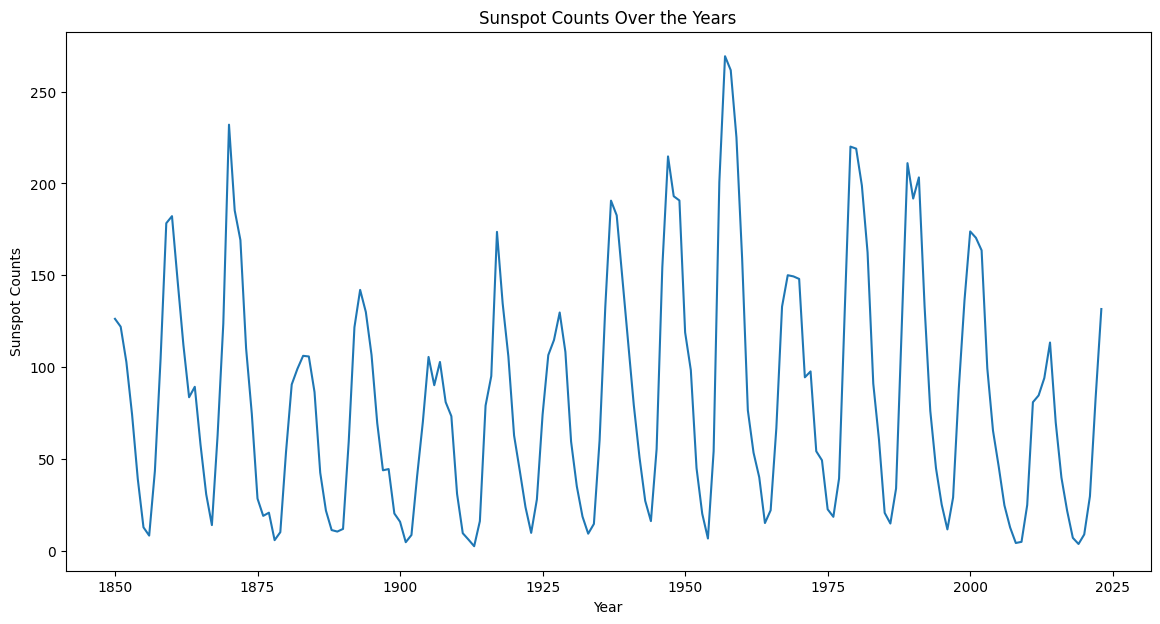

In [16]:
# Plotting the distribution of sunspot counts over the years
plt.figure(figsize=(14, 7))

# Line plot for sunspot counts over the years
sns.lineplot(data=df, x='year', y='counts', errorbar=None)

plt.title('Sunspot Counts Over the Years')
plt.xlabel('Year')
plt.ylabel('Sunspot Counts')
plt.show()

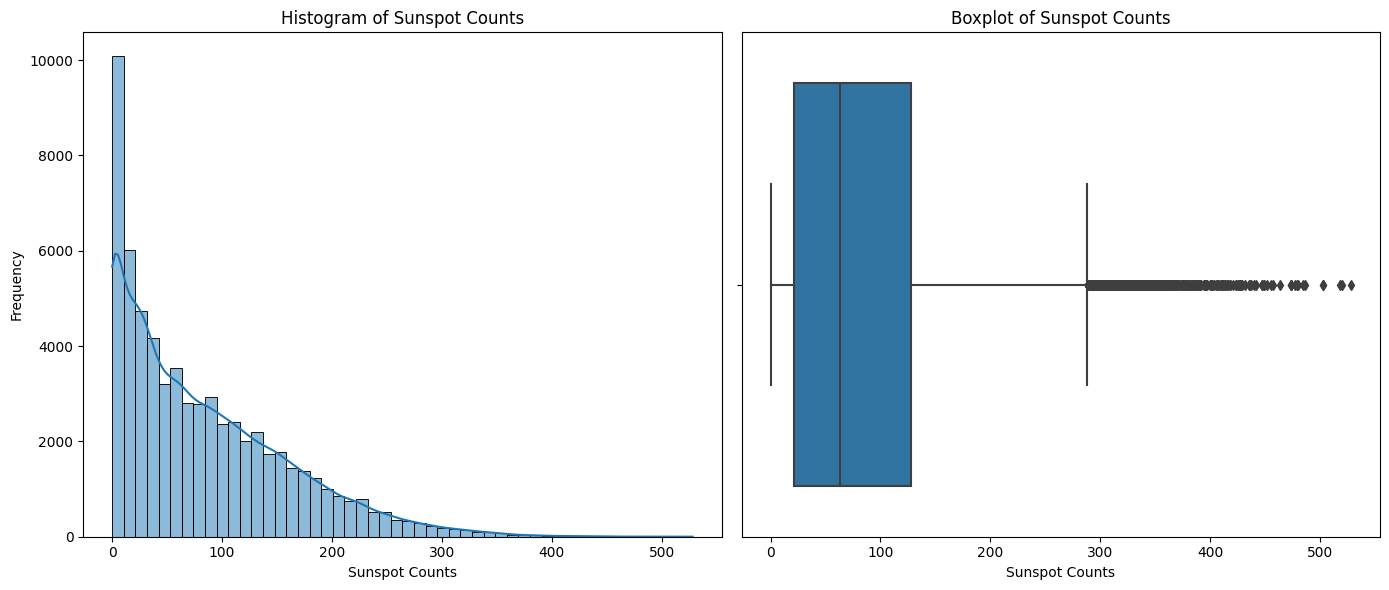

In [17]:
# Plotting the distribution of sunspot counts
plt.figure(figsize=(14, 6))

# Creating a histogram
plt.subplot(1, 2, 1)
sns.histplot(df['counts'], bins=50, kde=True)
plt.title('Histogram of Sunspot Counts')
plt.xlabel('Sunspot Counts')
plt.ylabel('Frequency')

# Creating a boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['counts'])
plt.title('Boxplot of Sunspot Counts')
plt.xlabel('Sunspot Counts')

# Display the plots
plt.tight_layout()
plt.show()

In [18]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [19]:
from sklearn.model_selection import train_test_split

time_train, x_train, time_valid, x_valid = train_test_split(series,
                                                            time_step,
                                                            test_size=0.2,
                                                            shuffle=False)

In [20]:
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

In [21]:
train_set = windowed_dataset(x_train,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer=shuffle_buffer_size)

In [36]:
class ThresholdedMAECallback(tf.keras.callbacks.Callback):
    def __init__(self , threshold):
        super(ThresholdedMAECallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current_mae = logs.get('mae')
        if current_mae < self.threshold:
            print(f"\nMAE has reached the threshold of ({self.threshold}), training is stopped.")
            self.model.stop_training = True

threshold_mae = (scaled_data['counts'].max() - scaled_data['counts'].min()) * 10/100
mae_callback = ThresholdedMAECallback(threshold_mae)

In [37]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                        strides=1, padding='causal',
                        activation='relu', input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)
])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 60)          360       
                                                                 
 lstm_2 (LSTM)               (None, None, 60)          29040     
                                                                 
 lstm_3 (LSTM)               (None, 60)                29040     
                                                                 
 dense_3 (Dense)             (None, 30)                1830      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [39]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

In [40]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [41]:
history = model.fit(train_set, epochs=100, callbacks=[mae_callback])

Epoch 1/100
    125/Unknown - 6s 21ms/step - loss: 0.2686 - mae: 0.5958
MAE has reached the threshold of (0.6862318880435678), training is stopped.
127/127 [==============================] - 6s 21ms/step - loss: 0.2667 - mae: 0.5931


<Figure size 640x480 with 0 Axes>

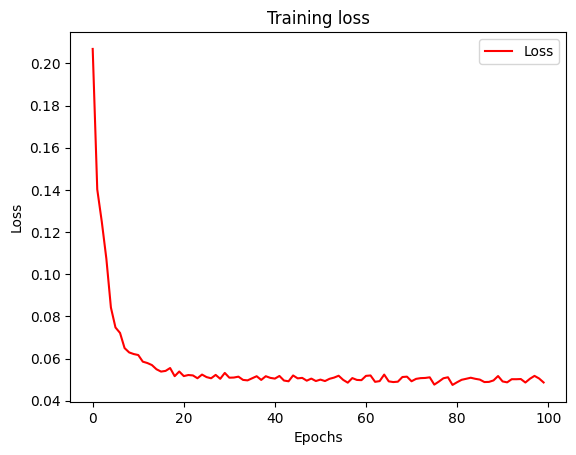

<Figure size 640x480 with 0 Axes>

In [ ]:
loss=history.history['loss']
epochs=range(len(loss))

plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()